In [2]:
!pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.0 MB/s eta 0:00:00


In [3]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.1 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense,Conv2D,MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision, Recall
import tensorflow as tf
import cv2
import random
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_path ='/content/drive/MyDrive/AutismDataset/train'
test_path = '/content/drive/MyDrive/AutismDataset/test'

In [7]:
file_names = np.array(os.listdir(train_path))
lable_name = []
file_path = []
for filename in file_names:
    category = filename.split('.')[0]
    file_path.append(train_path+'/'+filename)
    if category == 'Autistic':
        lable_name.append('Autistic')
    else:
        lable_name.append('Non_Autistic')
train_df = pd.DataFrame({
    'file_path': file_path,
    'label_name': lable_name
})

In [8]:
file_names_test = np.array(os.listdir(test_path))
lable_name_test = []
file_path_test = []
for filename in file_names_test:
    category = filename.split('.')[0]
    file_path_test.append(train_path+'/'+filename)
    if category == 'Autistic':
        lable_name_test.append('Autistic')
    else:
        lable_name_test.append('Non_Autistic')
test_df = pd.DataFrame({
    'file_path': file_path_test,
    'label_name': lable_name_test
})


In [9]:
train_df.head()

file_path    label_name
0  /content/drive/MyDrive/AutismDataset/train/Non...  Non_Autistic
1  /content/drive/MyDrive/AutismDataset/train/Non...  Non_Autistic
2  /content/drive/MyDrive/AutismDataset/train/Non...  Non_Autistic
3  /content/drive/MyDrive/AutismDataset/train/Non...  Non_Autistic
4  /content/drive/MyDrive/AutismDataset/train/Non...  Non_Autistic

In [10]:
test_df.head()

file_path label_name
0  /content/drive/MyDrive/AutismDataset/train/Aut...   Autistic
1  /content/drive/MyDrive/AutismDataset/train/Aut...   Autistic
2  /content/drive/MyDrive/AutismDataset/train/Aut...   Autistic
3  /content/drive/MyDrive/AutismDataset/train/Aut...   Autistic
4  /content/drive/MyDrive/AutismDataset/train/Aut...   Autistic

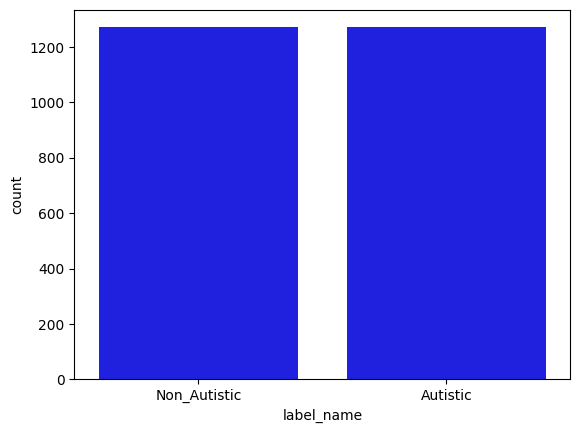

In [11]:
sns.set_palette(sns.color_palette(["b", "r"]))
sns.countplot(x =train_df['label_name'])
plt.show()

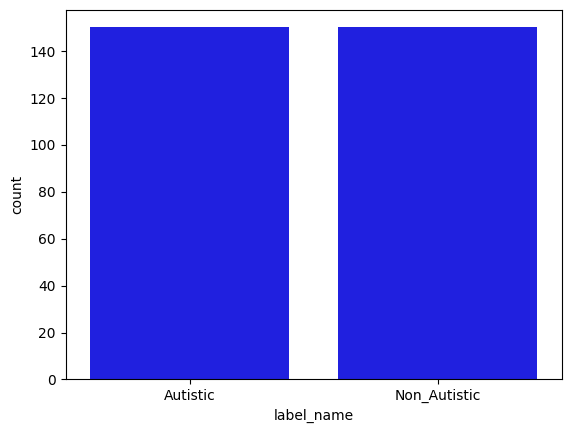

In [12]:
sns.set_palette(sns.color_palette(["b", "r"]))
sns.countplot(x =test_df['label_name'])
plt.show()

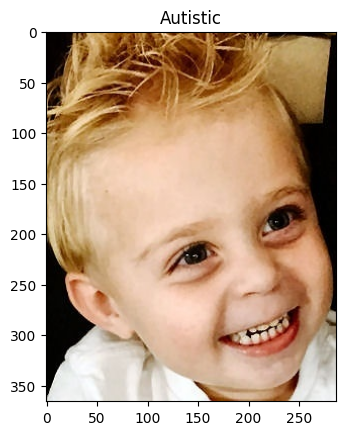

In [13]:
sample = random.choice(file_path)
image = plt.imread(sample)
plt.title(sample.split('/')[-1].split('.')[0])
plt.imshow(image)
plt.show()

In [14]:
train_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
#     preprocessing_function = efn.preprocess_input
)

# Only rescaling the val set
val_gen = ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
#     preprocessing_function = efn.preprocess_input
)

In [15]:
image_size = 224
input_shape = (image_size, image_size, 3)
epochs = 15
batch_size = 20

In [16]:
train_df, validate_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_train,total_validate

(2286, 254)

In [17]:
train_df.head()

index                                          file_path    label_name
0   1921  /content/drive/MyDrive/AutismDataset/train/Non...  Non_Autistic
1   1754  /content/drive/MyDrive/AutismDataset/train/Non...  Non_Autistic
2     29  /content/drive/MyDrive/AutismDataset/train/Non...  Non_Autistic
3   1242  /content/drive/MyDrive/AutismDataset/train/Aut...      Autistic
4   1708  /content/drive/MyDrive/AutismDataset/train/Aut...      Autistic

In [18]:
validate_df.head()

index                                          file_path    label_name
0   2015  /content/drive/MyDrive/AutismDataset/train/Aut...      Autistic
1    176  /content/drive/MyDrive/AutismDataset/train/Non...  Non_Autistic
2    768  /content/drive/MyDrive/AutismDataset/train/Non...  Non_Autistic
3   1689  /content/drive/MyDrive/AutismDataset/train/Aut...      Autistic
4     35  /content/drive/MyDrive/AutismDataset/train/Non...  Non_Autistic

In [19]:
train_set = train_gen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='label_name',
    target_size=(image_size,image_size),
    class_mode='categorical',
    shuffle=True,
    batch_size=batch_size)
val_set = val_gen.flow_from_dataframe(
    validate_df,
    x_col='file_path',
    y_col='label_name',
    target_size=(image_size,image_size),
    class_mode='categorical',
    shuffle=True,
    batch_size=batch_size)

Found 2286 validated image filenames belonging to 2 classes.
Found 254 validated image filenames belonging to 2 classes.


In [20]:
class_dict = {v:k for k,v in train_set.class_indices.items()}
class_dict

{0: 'Autistic', 1: 'Non_Autistic'}

In [21]:
train_set.image_shape,val_set.image_shape

((224, 224, 3), (224, 224, 3))

In [22]:
def see_examples(datagen, figsize=(16,16),nrows=4, ncols=4):
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    batch_idx = np.random.randint(low=0, high=len(datagen), size=(nrows,ncols))
    for i in range(nrows):
        for j in range(ncols):
            imgs, labels = datagen[batch_idx[i,j]]
            sample_idx = np.random.randint(low=0, high=len(imgs))
            img = imgs[sample_idx]
            label = labels[sample_idx]
            label = class_dict[np.argmax(label)]
            ax[i,j].axis('off')
            ax[i,j].imshow(img)
            ax[i,j].set_title(label)
    plt.show()

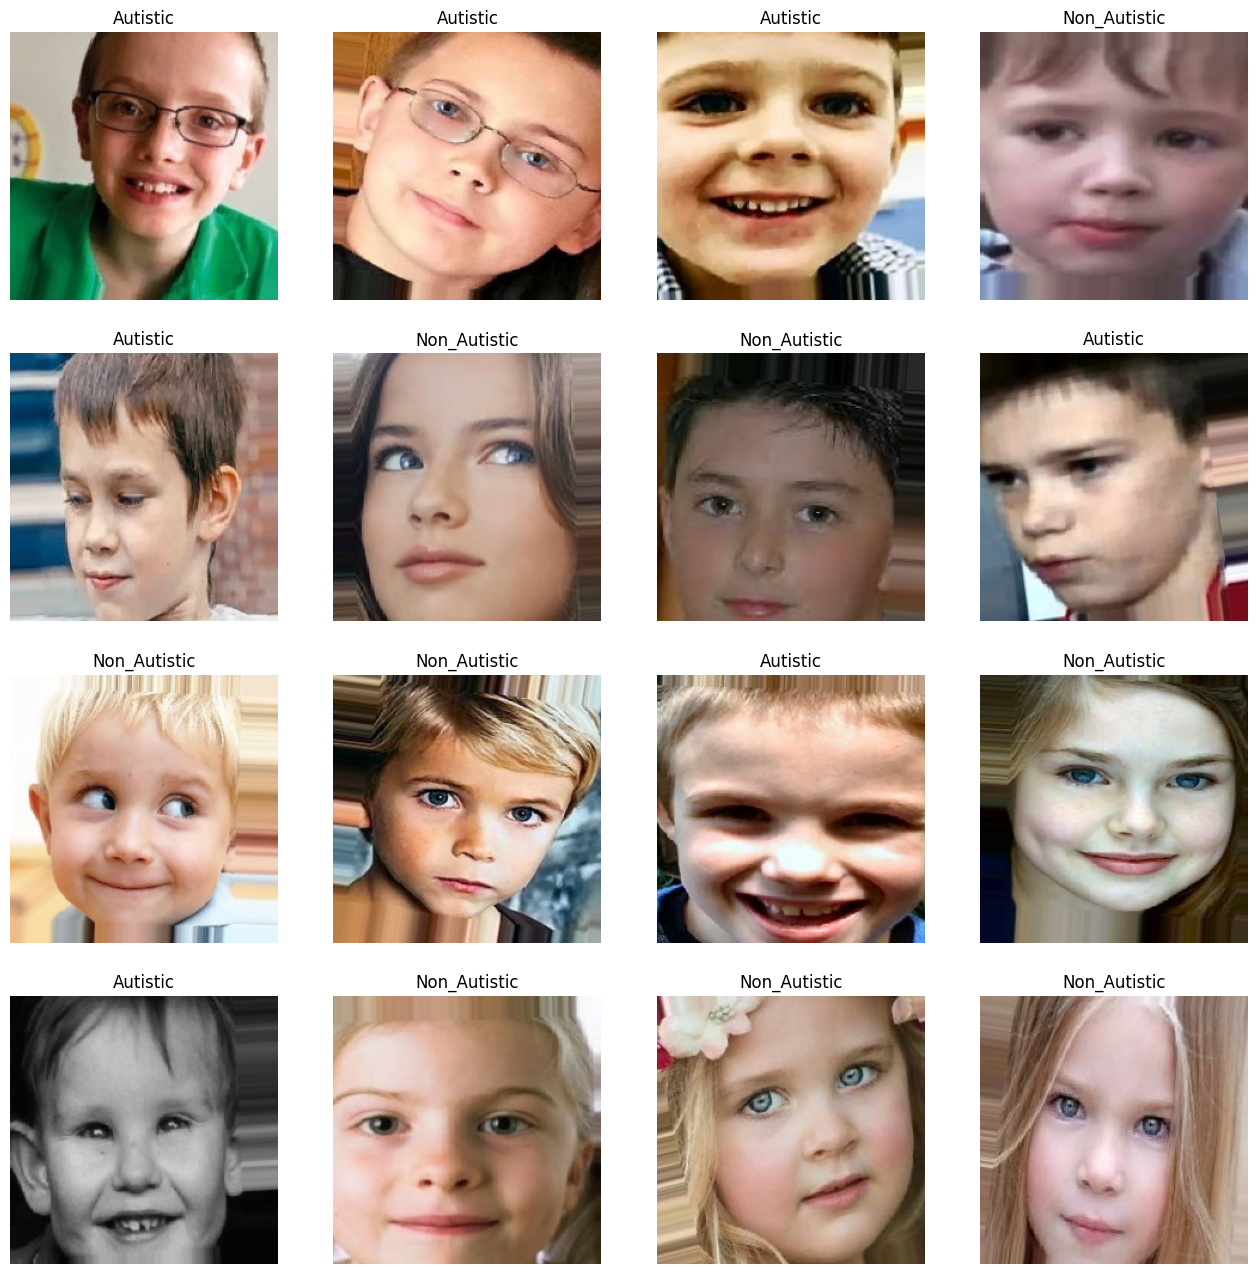

In [23]:
see_examples(train_set)

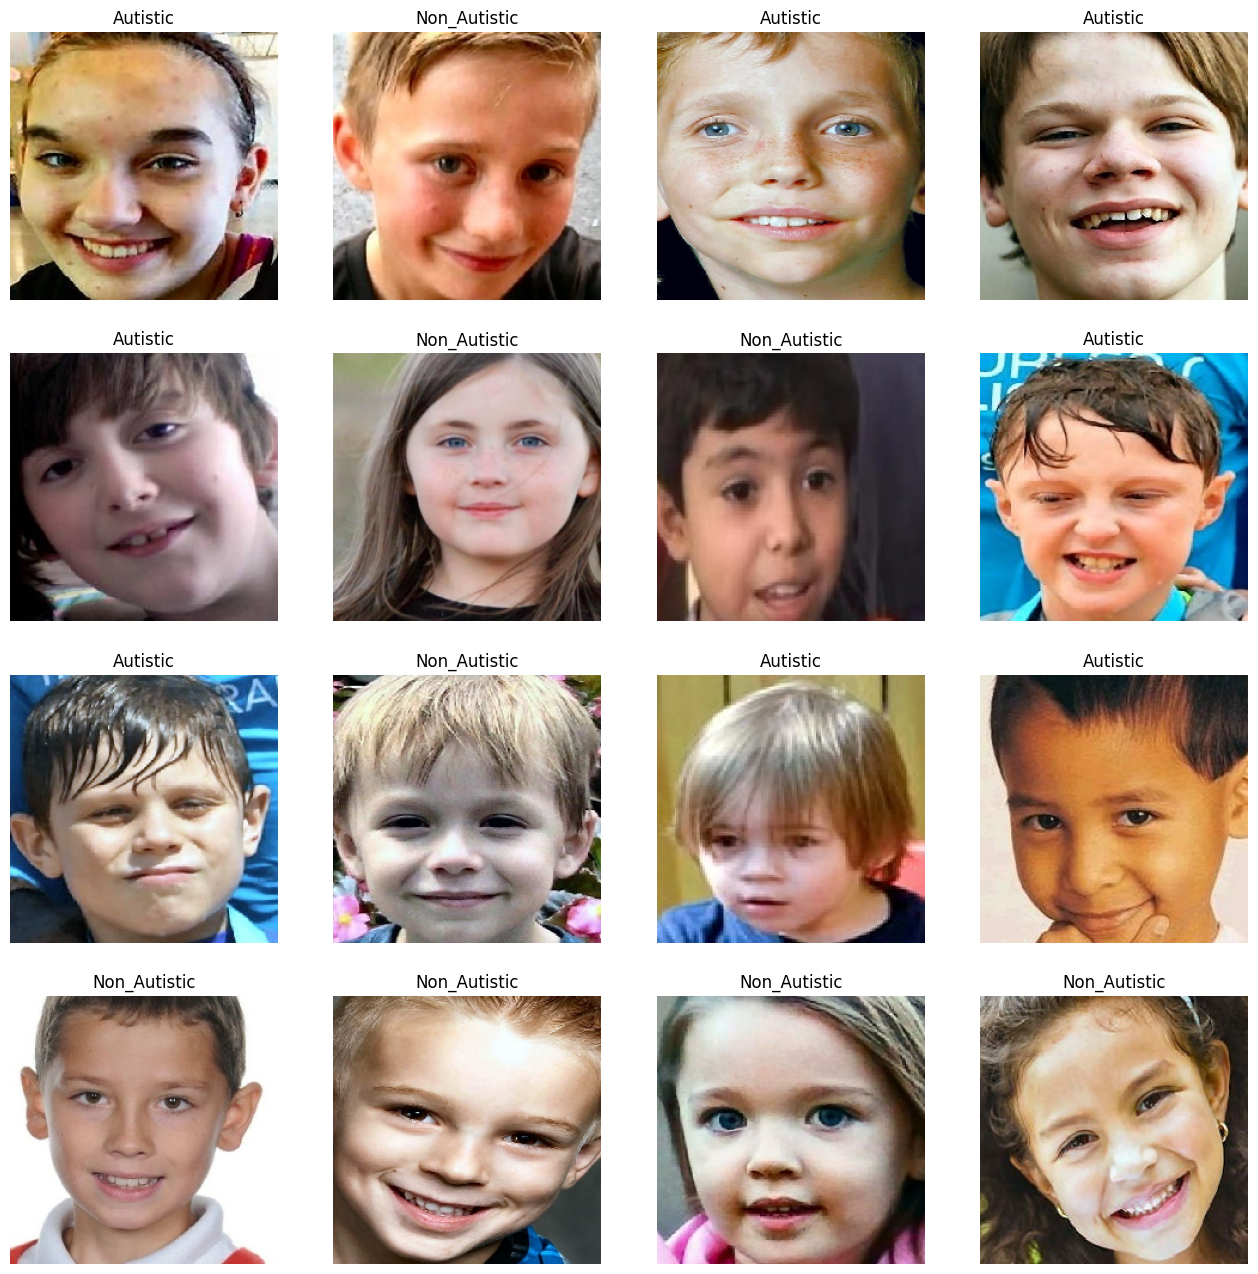

In [24]:
see_examples(val_set)

In [25]:
conv_base = efn.EfficientNetB0(input_shape=input_shape, include_top=False, weights="imagenet")
conv_base.trainable=True

16804768/16804768 [==============================] - 0s 0us/step


In [ ]:
# conv_base = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
# conv_base.trainable=False

In [26]:
input_shape

(224, 224, 3)

In [27]:
conv_base.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 112, 112, 32)         0         ['stem_bn[0][0]'

In [ ]:
# conv_base.trainable = True

# set_trainable = False
# for layer in conv_base.layers:
#     if layer.name == 'block6a_expand_conv':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

# conv_base.trainable = True

# set_trainable = False
# for layer in conv_base.layers:
#     if layer.name == 'block5_conv1':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

In [28]:
model = Sequential([
    conv_base,
    GlobalMaxPooling2D(),

    Dense(units=512,activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=2, activation='softmax')
])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 7, 7, 1280)        4049564   
 l)                                                              
                                                                 
 global_max_pooling2d (Glob  (None, 1280)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0

In [30]:
callbacks = [
    EarlyStopping(min_delta=1e-5, patience=10),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

metrics = [
    CategoricalAccuracy(),
#     F1Score(num_classes=2),
#     Precision(),
#     Recall(),
#     AUC()
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [32]:
history = model.fit_generator(train_set,epochs=epochs, steps_per_epoch=total_train//batch_size,
                  validation_data=val_set, validation_steps=total_validate//batch_size,callbacks= callbacks
                             )

<ipython-input-32-234de83ce516>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_set,epochs=epochs, steps_per_epoch=total_train//batch_size,


Epoch 1/15
114/114 [==============================] - 590s 5s/step - loss: 0.1868 - categorical_accuracy: 0.9206 - val_loss: 0.8441 - val_categorical_accuracy: 0.8000
Epoch 2/15
114/114 [==============================] - 595s 5s/step - loss: 0.1914 - categorical_accuracy: 0.9285 - val_loss: 0.3984 - val_categorical_accuracy: 0.8625
Epoch 3/15
114/114 [==============================] - 597s 5s/step - loss: 0.1987 - categorical_accuracy: 0.9250 - val_loss: 1.1693 - val_categorical_accuracy: 0.7333
Epoch 4/15
114/114 [==============================] - 594s 5s/step - loss: 0.1856 - categorical_accuracy: 0.9312 - val_loss: 0.8681 - val_categorical_accuracy: 0.8250
Epoch 5/15
114/114 [==============================] - 579s 5s/step - loss: 0.1911 - categorical_accuracy: 0.9228 - val_loss: 0.5197 - val_categorical_accuracy: 0.8167
Epoch 6/15
114/114 [==============================] - 580s 5s/step - loss: 0.1629 - categorical_accuracy: 0.9395 - val_loss: 0.5368 - val_categorical_accuracy: 0.858

In [ ]:
# pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

# last_layer = pre_trained_model.get_layer('block5_pool')
# last_output = last_layer.output

# # Flatten the output layer to 1 dimension
# x = GlobalMaxPooling2D()(last_output)
# # Add a fully connected layer with 512 hidden units and ReLU activation
# x = Dense(512, activation='relu')(x)
# # Add a dropout rate of 0.5
# x = Dropout(0.5)(x)
# # Add a final sigmoid layer for classification
# x = Dense(1, activation='sigmoid')(x)

# model = Model(pre_trained_model.input, x)

# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=metrics)

# model.summary()

In [ ]:
# history = model.fit_generator(
#     train_set,
#     epochs=epochs,
#     validation_data=val_set,
#     validation_steps=total_validate//batch_size,
#     steps_per_epoch=total_train//batch_size,
#     callbacks= callbacks)

In [33]:
history_df = pd.DataFrame(history.history)
history_df.tail()

loss  categorical_accuracy  val_loss  val_categorical_accuracy
10  0.149861              0.941748  0.462915                  0.829167
11  0.194250              0.927626  0.376197                  0.866667
12  0.130101              0.953222  0.664190                  0.862500
13  0.133636              0.949691  0.602065                  0.858333
14  0.117723              0.959400  0.558073                  0.841667

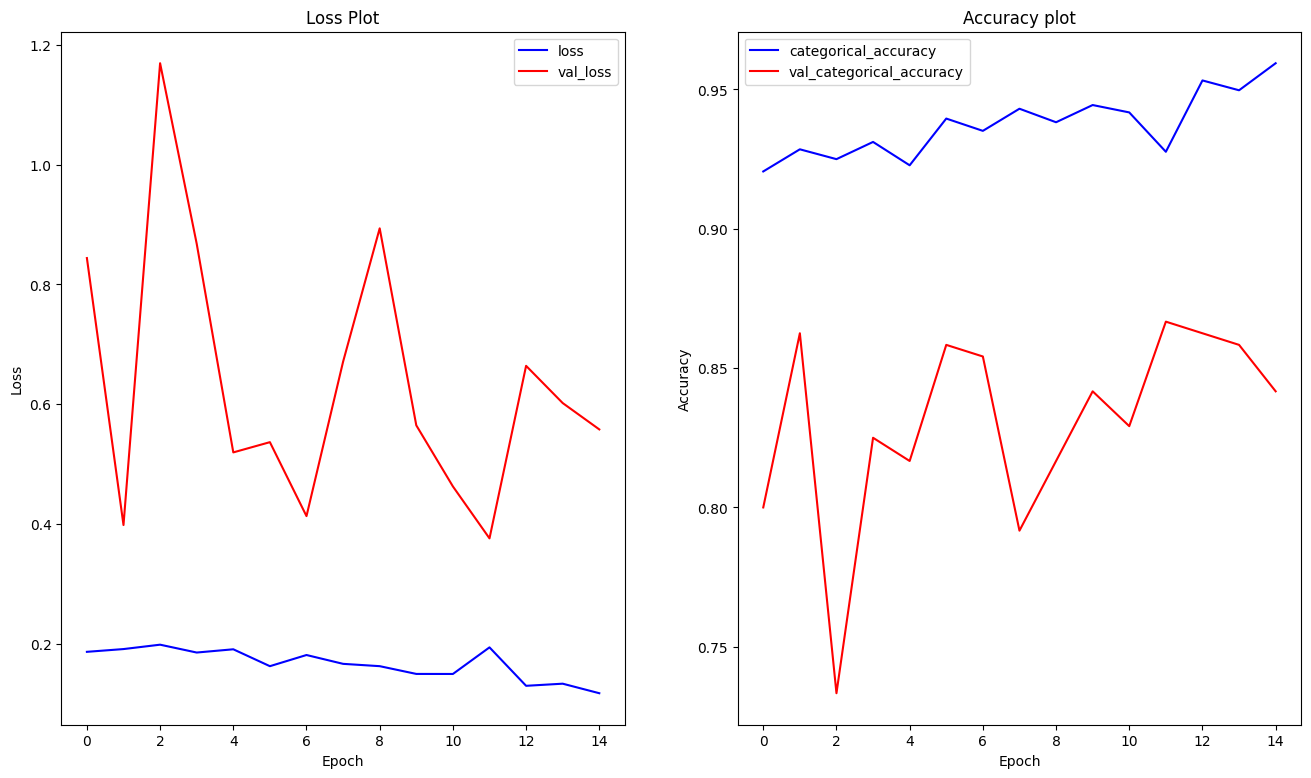

In [34]:
fig, ax = plt.subplots(figsize=(16,9), nrows=1,ncols=2)
history_df[['loss','val_loss']].plot(ax=ax[0], xlabel='Epoch',ylabel='Loss', title='Loss Plot')
history_df[['categorical_accuracy','val_categorical_accuracy']].plot(
    ax=ax[1], xlabel='Epoch',ylabel='Accuracy',title='Accuracy plot')
plt.show()

In [35]:
val_set_final = val_gen.flow_from_dataframe(
    test_df,x_col='file_path',
    y_col='label_name',
    class_mode='categorical',
    target_size=(image_size,image_size),
    batch_size=batch_size,
    shuffle=False)

Found 300 validated image filenames belonging to 2 classes.


In [36]:
best_model = load_model('best_model.h5')

In [37]:
val_loss,val_acc = best_model.evaluate(val_set_final)
val_preds = best_model.predict(val_set_final)
val_preds = val_preds.argmax(axis=1)
test_df.head()

15/15 [==============================] - 21s 1s/step


file_path label_name
0  /content/drive/MyDrive/AutismDataset/train/Aut...   Autistic
1  /content/drive/MyDrive/AutismDataset/train/Aut...   Autistic
2  /content/drive/MyDrive/AutismDataset/train/Aut...   Autistic
3  /content/drive/MyDrive/AutismDataset/train/Aut...   Autistic
4  /content/drive/MyDrive/AutismDataset/train/Aut...   Autistic

In [38]:
val_set.class_indices

{'Autistic': 0, 'Non_Autistic': 1}

In [39]:
test_df['Label'] = test_df['label_name'].map(val_set.class_indices)
test_df['Predicted'] = val_preds
test_df.head()

file_path label_name  Label  \
0  /content/drive/MyDrive/AutismDataset/train/Aut...   Autistic      0   
1  /content/drive/MyDrive/AutismDataset/train/Aut...   Autistic      0   
2  /content/drive/MyDrive/AutismDataset/train/Aut...   Autistic      0   
3  /content/drive/MyDrive/AutismDataset/train/Aut...   Autistic      0   
4  /content/drive/MyDrive/AutismDataset/train/Aut...   Autistic      0   

   Predicted  
0          0  
1          0  
2          0  
3          0  
4          1

In [40]:
conf_mat = confusion_matrix(y_true=test_df['Label'], y_pred=test_df['Predicted'])
conf_mat = pd.DataFrame(conf_mat, index=val_set_final.class_indices.keys(), columns=val_set_final.class_indices.keys())

In [ ]:
conf_mat

Autistic  Non_Autistic
Autistic           130            20
Non_Autistic        44           106

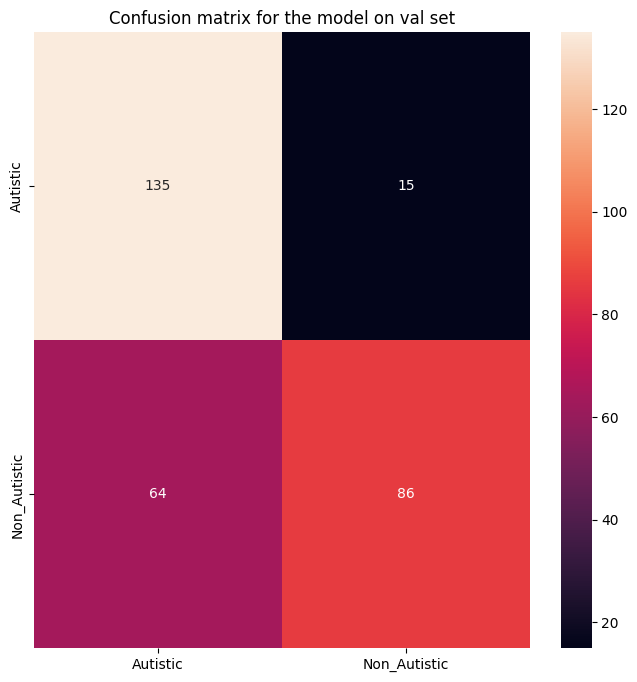

In [41]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, ax=ax , fmt='d')
ax.set_title('Confusion matrix for the model on val set')
plt.show()

In [42]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [70]:
print(history.history['categorical_accuracy'][-1])

0.9593998193740845
